![Fixel Algorithms](https://fixelalgorithms.co/images/CCExt.png)

# <center> Machine Learning Methods </center>
## <center> Lecture 11 - Non-linear Least Squares</center>
### <center> Newton's Method </center>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/FixelAlgorithmsTeam/FixelCourses/blob/master/MachineLearningMethod/11_NonLinearLeastSquares/MainNewtonsMethod.ipynb)

In [9]:
import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rc('font', **{'size' : 16})

### Rosenbrock function:
![](https://upload.wikimedia.org/wikipedia/commons/thumb/3/32/Rosenbrock_function.svg/300px-Rosenbrock_function.svg.png)
$$f\left(x_{1},x_{2}\right)=\left(1-x_{1}\right)^{2}+100\left(x_{2}-x_{1}^{2}\right)^{2}$$
$$\nabla f\left(x_{1},x_{2}\right)=\left[\begin{matrix}-2\left(1-x_{1}\right)-400x_{1}\left(x_{2}-x_{1}^{2}\right)\\
200\left(x_{2}-x_{1}^{2}\right)
\end{matrix}\right]$$
$$\nabla^{2}f\left(x_{1},x_{2}\right)=\left[\begin{matrix}2-400\left(x_{2}-3x_{1}^{2}\right) & -400x_{1}\\
-400x_{1} & 200
\end{matrix}\right]$$

In [10]:
def f(vX):
    x1 = vX[0]
    x2 = vX[1]
    return (1 - x1)**2 + 100 * (x2 - x1**2)**2

def Df(vX):
    x1 = vX[0]
    x2 = vX[1]
    return np.array([-2 * (1 - x1) - 400*x1*(x2 - x1**2),
                     200 * (x2 - x1**2)])

def DDf(vX):
    x1 = vX[0]
    x2 = vX[1]
    return np.array([[2 - 400*(x2 - 3*x1**2), -400*x1],
                     [-400*x1,    200]])

### Symbolic Python (SymPy):

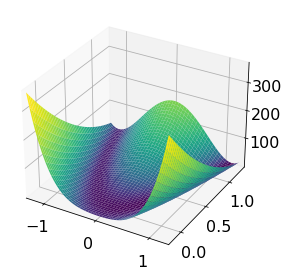

In [11]:
from sympy          import symbols
from sympy.plotting import plot3d

x1, x2 = symbols('x_1 x_2')
Color  = lambda x1, x2: np.log(f([x1, x2])+10)
plot3d(f([x1, x2]), (x1, -1.3, 1.3), (x2, -.2, 1.3), surface_color=Color)

### Vanilla gradient descent:
$$\boldsymbol{x}^{\left(t+1\right)}=\boldsymbol{x}^{\left(t\right)}-\mu\nabla f\left(\boldsymbol{x}^{\left(t\right)}\right)$$

In [12]:
import time

def GradientDescent(f, Df, vX0, µ, K):
    vF    = np.full(K, np.nan)
    vTime = np.full(K, np.nan)

    vX       = vX0.copy()
    vF[0]    = f(vX)
    vTime[0] = time.time()
    for ii in range(1, K):
        vX -= µ * Df(vX)

        vTime[ii] = time.time()
        vF[ii]    = f(vX)

    vTime -= vTime[0]
    return vF, vTime

### Gradient descent with line search:
$$\boldsymbol{x}^{\left(t\right)}=\boldsymbol{x}^{\left(t-1\right)}-\alpha^{\left(t\right)}\nabla f\left(\boldsymbol{x}\right)$$
1. **while** $\psi\left(\alpha\right)>\psi\left(0\right)+c\alpha\psi'\left(0\right)$:  
    * $\alpha\leftarrow\frac{1}{2}\alpha$
    
where:
$$\psi\left(\alpha\right):=f\left(\boldsymbol{x}^{\left(t\right)}+\alpha\boldsymbol{h}\right)$$
$$\boldsymbol{h}=-\nabla f\left(\boldsymbol{x}^{\left(t\right)}\right)$$
$$\psi\left(0\right)=f\left(\boldsymbol{x}^{\left(t\right)}\right)$$
$$m=\psi'\left(0\right)=\left\langle \nabla f\left(\boldsymbol{x}^{\left(t\right)}\right),\boldsymbol{h}\right\rangle $$

In [110]:
def GradientDescentWithLineSearch(f, Df, vX0, α0, c, K):
    vF    = np.full(K, np.nan)
    vTime = np.full(K, np.nan)

    vX       = vX0.copy()
    vF[0]    = f(vX)
    vTime[0] = time.time()
    for ii in range(1, K):
        vG   = Df(vX)            #-- gradient
        vH   = -vG                #-- descent direction
        m    = np.inner(vG, vH)   #-- slope
        f0   = vF[ii-1]

        #-- Line search:
        α    = α0
        fα   = f(vX + α * vH)
        while fα > f0 + c * α * m:
            α  *= .5
            fα  = f(vX + α * vH)

#         α0        = 4 * α
        vX       += α * vH
        vTime[ii] = time.time()
        vF[ii]    = fα

    vTime -= vTime[0]
    return vF, vTime

### Newton's Method (with line search):
$$\boldsymbol{x}^{\left(t\right)}=\boldsymbol{x}^{\left(t-1\right)}+\alpha^{\left(t\right)}\boldsymbol{h}^{\left(t\right)}$$
where:
$$\boldsymbol{h}^{\left(t\right)}=-\left(\nabla^{2}f\right)^{-1}\nabla L=-\boldsymbol{H}^{-1}\boldsymbol{g}$$
$$\boldsymbol{g}:=\nabla f\left(\boldsymbol{x}\right)$$
$$\boldsymbol{H}:=\nabla^{2}f\left(\boldsymbol{x}\right)$$

In [111]:
def NewtonsMethod(f, Df, DDf, vX0, α0, c, K):
    vF    = np.full(K, np.nan)
    vTime = np.full(K, np.nan)

    vX       = vX0.copy()
    vF[0]    = f(vX)
    vTime[0] = time.time()
    for ii in range(1, K):
        vG   = Df(vX)                   #-- gradient
        mH   = DDf(vX)                  #-- Hessian
        vH   = np.linalg.solve(mH, -vG) #-- descent direction
        m    = np.inner(vG, vH)         #-- slope
        f0   = vF[ii-1]

        #-- Line search:
        α    = α0
        fα   = f(vX + α * vH)
        while fα > f0 + c * α * m:
            α  *= .5
            fα  = f(vX + α * vH)

#         α0        = 4 * α
        vX       += α * vH
        vTime[ii] = time.time()
        vF[ii]    = fα

    vTime -= vTime[0]
    return vF, vTime

In [152]:
vX0 = np.array([1.4, 1.2])

#-- GD:
µ                     = .0020 #-- step size:
K                     = 10000 #-- number of iterations:
vObjectiveGD, vTimeGD = GradientDescent(f, Df, vX0, µ, K)

#-- GD with LS:
α0                    = 1.01
c                     = .7
K                     = 1000
vObjectiveLS, vTimeLS = GradientDescentWithLineSearch(f, Df, vX0, α0, c, K)

#-- Newtho's method:
α0                    = .5
c                     = 0.25
K                     = 200
vObjectiveNM, vTimeNM = NewtonsMethod(f, Df, DDf, vX0, α0, c, K)

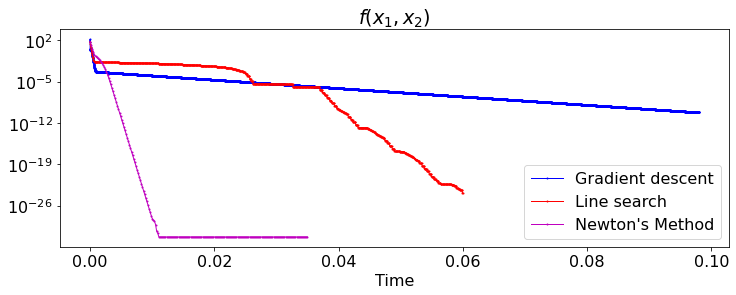

In [153]:
def TimeAxis(vT):
    return np.linspace(vT[0], vT[-1], len(vT))

plt.figure(figsize=(12, 4))
plt.plot(TimeAxis(vTimeGD), vObjectiveGD, c='b', lw=1, marker='.', ms=2, label='Gradient descent')
plt.plot(TimeAxis(vTimeLS), vObjectiveLS, c='r', lw=1, marker='.', ms=2, label='Line search')
plt.plot(TimeAxis(vTimeNM), vObjectiveNM, c='m', lw=1, marker='.', ms=2, label="Newton's Method")
plt.title('$f(x_1, x_2)$')
plt.xlabel('Time')
plt.yscale('log')
plt.legend()
plt.show()

### Example II:
$$f\left(\boldsymbol{x}\right)=\left\Vert \boldsymbol{y}-\boldsymbol{A}\boldsymbol{x}\right\Vert _{2}^{2}$$
$$\nabla f=-2\boldsymbol{A}^{T}\left(\boldsymbol{y}-\boldsymbol{A}\boldsymbol{x}\right)$$
$$\nabla^{2}f\left(\boldsymbol{x}\right)=2\boldsymbol{A}^{T}\boldsymbol{A}$$

In [154]:
d     = 1000                          #-- dimension
mA    = np.random.randn(d, d)         #-- some random SPD matrix
mA    = mA @ mA.T / d + 1 * np.eye(d)
vOptX = np.random.randn(d)            #-- true x
vY    = mA @ vOptX                    #-- y

def f(vX):
    return np.linalg.norm(vY - mA @ vX)**2

def Df(vX):
    return -2 * mA.T @ (vY - mA @ vX)

def DDf(vX):
    return 2 * mA.T @ mA

In [155]:
vX0 = vY

#-- GD:
µ                     = .01  #-- step size:
K                     = 100 #-- number of iterations:
vObjectiveGD, vTimeGD = GradientDescent(f, Df, vX0, µ, K)

#-- GD with LS:
α0                    = 1
c                     = 0.6
K                     = 50
vObjectiveLS, vTimeLS = GradientDescentWithLineSearch(f, Df, vX0, α0, c, K)

#-- Newtho's method:
α0                    = 1
c                     = .25
K                     = 5
vObjectiveNM, vTimeNM = NewtonsMethod(f, Df, DDf, vX0, α0, c, K)

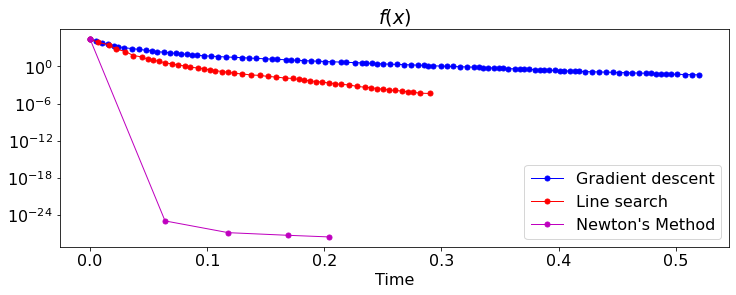

In [156]:
plt.figure(figsize=(12, 4))
plt.plot(vTimeGD, vObjectiveGD, c='b', lw=1, marker='.', ms=10, label='Gradient descent')
plt.plot(vTimeLS, vObjectiveLS, c='r', lw=1, marker='.', ms=10, label='Line search')
plt.plot(vTimeNM, vObjectiveNM, c='m', lw=1, marker='.', ms=10, label="Newton's Method")
plt.title('$f(x)$')
plt.xlabel('Time')
plt.yscale('log')
plt.legend()
plt.show()